In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
## Copy gizmo package file from Google Drive to Colab Instance
!cp -r /content/drive/MyDrive/AC297r/gizmo/ ./gizmo

## Locally install `gizmo`
%cd gizmo
!pip install -e .

# Clone teamBlueConduit and install necessary packages and 
!git clone https://github.com/mcembalest/teamBlueConduit.git
%cd teamBlueConduit
!pip install .
!pip install -r requirements.txt > /dev/null

## MAKE SURE TO RESTART KERNEL!

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components#n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)

import io
import pickle
import zipfile

###########
# import our libraries
from blue_conduit_spatial.utilities import *
from blue_conduit_spatial.evaluation import *
from blue_conduit_spatial.distance_matrix import *
from blue_conduit_spatial.modeling.diffusion import ServiceLineDiffusion

LAT_MIN, LAT_MAX = 42.97, 43.09
LON_MIN, LON_MAX = -83.75, -83.62

########### set random state
np.random.seed(297)

In [ ]:
!ls ' # FILEPATH TO LOAD'

Predictions  Processed	Raw  Tuning


In [ ]:
data_dir = '# FILEPATH OF DATA DIR'
load_dir = f'{data_dir}/Processed'
pred_dir = f'{data_dir}/Predictions'
pid_lat_lon_path = f'{load_dir}/pid.gpkg'
train_pred_path = f'{pred_dir}/pred_probs_train.npz'
test_pred_path = f'{pred_dir}/pred_probs_test.npz'

Xdata, Ydata, location, train_pid_all, test_pid_all, partitions_builder = load_datasets(load_dir)
train_pred_all, test_pred_all = load_predictions(pred_dir, 'baseline')

In [ ]:
# Load data
train_size = 'ts_0.1'
resolution = 'res_47'
split = 0

train_pid = train_pid_all[train_size][resolution][split]
test_pid = test_pid_all[train_size][resolution][split]

Xtrain = Xdata.loc[train_pid]
Xtest = Xdata.loc[test_pid]
Ytrain = Ydata.loc[train_pid]['dangerous'].values.astype('float')
Ytest = Ydata.loc[test_pid]['dangerous'].values.astype('float')
train_pred = train_pred_all[train_size][resolution][split]
test_pred = test_pred_all[train_size][resolution][split]
pid_lat_lon_train = location.loc[train_pid]
pid_lat_lon_test = location.loc[test_pid]

location['orig_index'] = np.arange(location.shape[0])
train_graph_index = location.loc[train_pid, 'orig_index'].values
test_graph_index = location.loc[test_pid, 'orig_index'].values

Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape, train_pid.shape, test_pid.shape, train_graph_index.shape, test_graph_index.shape

((2354, 301),
 (19293, 301),
 (2354,),
 (19293,),
 (2354,),
 (19293,),
 (2354,),
 (19293,))

In [ ]:
# load distance data
# this part is slow
dis_path = f'{load_dir}/road_distances.npz'
distances = np.load(dis_path, allow_pickle=True)

graph = distances['road_distances']
graph[graph==(1.00e+05)]=0.0 #assign invalid 1e5 values to be 0

print('graph', graph.shape)

graph (26857, 26857)


In [ ]:
hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=22)
print(hexagons.partition_gdf.geometry[0].area)

2021-11-18 17:14.09 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 15542.03it/s]

2021-11-18 17:14.12 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 17:14.12 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 17:14.15 [debug    ] Total parcels after join: 26857
2021-11-18 17:14.15 [info     ] Building the connected graph on the partitions.
2021-11-18 17:14.16 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
4380306.001931773


(19293,) (21647, 82)


/usr/local/lib/python3.7/dist-packages/blue_conduit_spatial/modeling/diffusion.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lead_vals = np.array([self._get_lead_value(idx) for idx in range(self.graph.shape[0])]).flatten().astype(float)


Initial Log Loss: 0.33
Log Loss at Iteration 1: 0.28


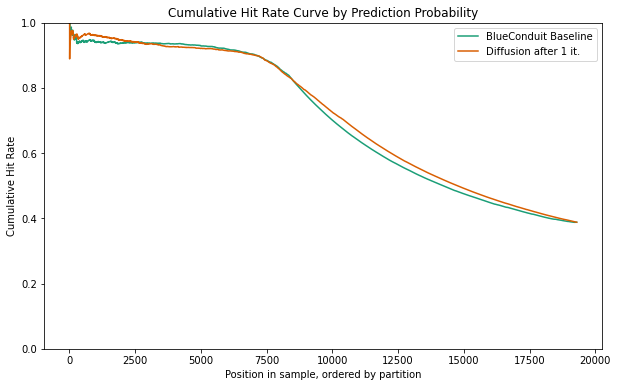

/usr/local/lib/python3.7/dist-packages/blue_conduit_spatial/modeling/diffusion.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lead_vals = np.array([self._get_lead_value(idx) for idx in range(self.graph.shape[0])]).flatten().astype(float)


Initial Log Loss: 0.28
Log Loss at Iteration 1: 0.31


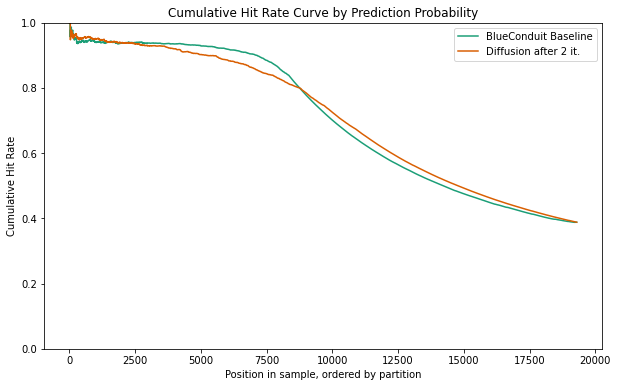

/usr/local/lib/python3.7/dist-packages/blue_conduit_spatial/modeling/diffusion.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lead_vals = np.array([self._get_lead_value(idx) for idx in range(self.graph.shape[0])]).flatten().astype(float)


Initial Log Loss: 0.31
Log Loss at Iteration 1: 0.34


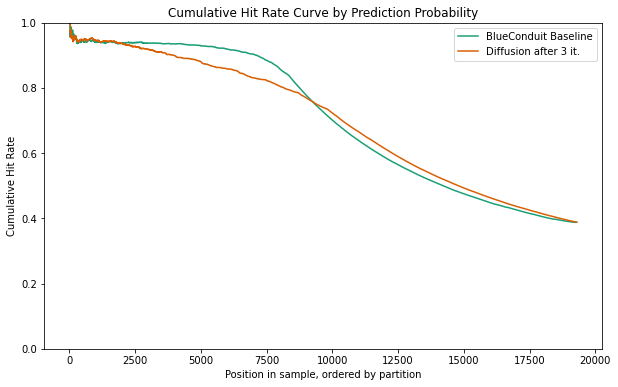

/usr/local/lib/python3.7/dist-packages/blue_conduit_spatial/modeling/diffusion.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lead_vals = np.array([self._get_lead_value(idx) for idx in range(self.graph.shape[0])]).flatten().astype(float)


Initial Log Loss: 0.34
Log Loss at Iteration 1: 0.37
Log Loss at Iteration 2: 0.38
Log Loss at Iteration 3: 0.38
Log Loss at Iteration 4: 0.39
Log Loss at Iteration 5: 0.39


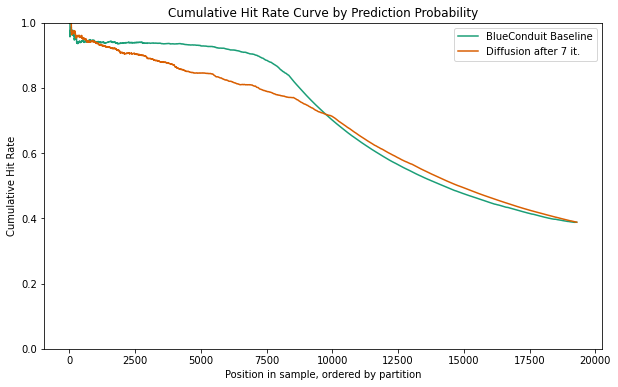

In [ ]:
# Use ServiceLineDiffusion class (i.e. modularized version)
print(test_pred.shape, hexagons.parcel_gdf.shape)
slg = ServiceLineDiffusion(graph, train_graph_index, test_graph_index, Ytrain, Ytest, train_pred, test_pred)
for i in range(3):
  out = slg.fit(n_iter=1, verbose=True)
  plot_hit_rate_curve(Ytest, [test_pred, slg.curr_test_pred], plot_probs=False, labels=['BlueConduit Baseline', f'Diffusion after {i+1} it.'], 
                      mode='partition', parcel_df=hexagons.parcel_gdf, pid_list=test_pid, threshold_init=0.9)

out = slg.fit(n_iter=5, verbose=True)
plot_hit_rate_curve(Ytest, [test_pred, slg.curr_test_pred], plot_probs=False, labels=['BlueConduit Baseline', f'Diffusion after {i+5} it.'], 
                    mode='partition', parcel_df=hexagons.parcel_gdf, pid_list=test_pid, threshold_init=0.9)

## Compare Over Splits

In [ ]:
resolutions = [5, 10, 22, 47, 99]
train_sizes = [0.1, 0.3, 0.4, 0.6, 0.7, 0.9]
n_iter = 1
lam_list = np.linspace(0.6, 1, 11)
k_list = [1, 5, 10, 50, 100]
plot_dir = '/content/drive/MyDrive/AC297r/Plots/'
!ls '/content/drive/MyDrive/AC297r/Plots'

diffusion  graphsage  stacking


In [ ]:
pd.options.mode.chained_assignment = None 
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

In [ ]:
train_pid_all['ts_0.1'].keys()

dict_keys(['res_5', 'res_10', 'res_22', 'res_47', 'res_99'])

In [ ]:
hex_size = 5
hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=hex_size)
result_dict  = select_data(Xdata, 
                                  Ydata, 
                                  location, 
                                  train_pid_all, 
                                  test_pid_all, 
                                  train_pred_all, 
                                  test_pred_all,
                                  partitions_builder, 
                                  train_size=0.1,
                                  n_hexagons=hex_size,
                                  split=0, 
                                  generate_hexagons=False)

result_dict['test_pred'].shape, result_dict['test_pid'].shape

2021-11-18 01:02.31 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 9638.05it/s]

2021-11-18 01:02.34 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:02.34 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:02.37 [debug    ] Total parcels after join: 26857
2021-11-18 01:02.37 [info     ] Building the connected graph on the partitions.
2021-11-18 01:02.37 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory


((23793,), (23793,))

2021-11-18 01:02.43 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 10791.52it/s]

2021-11-18 01:02.46 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:02.46 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:02.48 [debug    ] Total parcels after join: 26857
2021-11-18 01:02.49 [info     ] Building the connected graph on the partitions.
2021-11-18 01:02.49 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:03.15 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 16675.00it/s]

2021-11-18 01:03.18 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:03.18 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:03.21 [debug    ] Total parcels after join: 26857
2021-11-18 01:03.21 [info     ] Building the connected graph on the partitions.
2021-11-18 01:03.21 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:03.49 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 17852.83it/s]

2021-11-18 01:03.52 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:03.52 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:03.54 [debug    ] Total parcels after join: 26857
2021-11-18 01:03.54 [info     ] Building the connected graph on the partitions.
2021-11-18 01:03.55 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:04.27 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 21723.54it/s]

2021-11-18 01:04.30 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:04.30 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:04.33 [debug    ] Total parcels after join: 26857
2021-11-18 01:04.33 [info     ] Building the connected graph on the partitions.
2021-11-18 01:04.36 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:05.17 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 21691.10it/s]

2021-11-18 01:05.20 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:05.20 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:05.23 [debug    ] Total parcels after join: 26857
2021-11-18 01:05.23 [info     ] Building the connected graph on the partitions.
2021-11-18 01:05.46 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:06.39 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 10059.01it/s]

2021-11-18 01:06.42 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:06.42 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:06.45 [debug    ] Total parcels after join: 26857
2021-11-18 01:06.45 [info     ] Building the connected graph on the partitions.
2021-11-18 01:06.45 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:07.11 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 9577.17it/s]

2021-11-18 01:07.14 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:07.14 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:07.16 [debug    ] Total parcels after join: 26857
2021-11-18 01:07.16 [info     ] Building the connected graph on the partitions.
2021-11-18 01:07.16 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...


/usr/local/lib/python3.7/dist-packages/blue_conduit_spatial/evaluation/evaluation_plots.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


2021-11-18 01:07.43 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 17270.35it/s]

2021-11-18 01:07.46 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:07.46 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:07.49 [debug    ] Total parcels after join: 26857
2021-11-18 01:07.49 [info     ] Building the connected graph on the partitions.
2021-11-18 01:07.50 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:08.20 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 21820.37it/s]

2021-11-18 01:08.23 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:08.23 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:08.26 [debug    ] Total parcels after join: 26857
2021-11-18 01:08.26 [info     ] Building the connected graph on the partitions.
2021-11-18 01:08.29 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:09.07 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 21008.46it/s]

2021-11-18 01:09.10 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:09.10 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:09.13 [debug    ] Total parcels after join: 26857
2021-11-18 01:09.13 [info     ] Building the connected graph on the partitions.
2021-11-18 01:09.36 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:10.21 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 9496.54it/s]

2021-11-18 01:10.24 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:10.24 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:10.26 [debug    ] Total parcels after join: 26857
2021-11-18 01:10.27 [info     ] Building the connected graph on the partitions.
2021-11-18 01:10.27 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:11.00 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 13834.29it/s]

2021-11-18 01:11.03 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:11.03 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:11.05 [debug    ] Total parcels after join: 26857
2021-11-18 01:11.05 [info     ] Building the connected graph on the partitions.
2021-11-18 01:11.05 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:11.32 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 17256.58it/s]

2021-11-18 01:11.35 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:11.35 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:11.37 [debug    ] Total parcels after join: 26857
2021-11-18 01:11.38 [info     ] Building the connected graph on the partitions.
2021-11-18 01:11.38 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:12.08 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 20663.56it/s]

2021-11-18 01:12.11 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:12.11 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:12.13 [debug    ] Total parcels after join: 26857
2021-11-18 01:12.13 [info     ] Building the connected graph on the partitions.
2021-11-18 01:12.17 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:12.53 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 21074.14it/s]

2021-11-18 01:12.56 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:12.56 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:12.59 [debug    ] Total parcels after join: 26857
2021-11-18 01:12.59 [info     ] Building the connected graph on the partitions.
2021-11-18 01:13.22 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:14.05 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 7290.22it/s]

2021-11-18 01:14.08 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:14.08 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:14.10 [debug    ] Total parcels after join: 26857
2021-11-18 01:14.11 [info     ] Building the connected graph on the partitions.
2021-11-18 01:14.11 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:14.35 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 11964.64it/s]

2021-11-18 01:14.38 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:14.38 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:14.41 [debug    ] Total parcels after join: 26857
2021-11-18 01:14.41 [info     ] Building the connected graph on the partitions.
2021-11-18 01:14.41 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:15.07 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 20199.53it/s]

2021-11-18 01:15.09 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:15.09 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:15.12 [debug    ] Total parcels after join: 26857
2021-11-18 01:15.12 [info     ] Building the connected graph on the partitions.
2021-11-18 01:15.13 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:15.41 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 21730.46it/s]

2021-11-18 01:15.43 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:15.43 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:15.46 [debug    ] Total parcels after join: 26857
2021-11-18 01:15.46 [info     ] Building the connected graph on the partitions.
2021-11-18 01:15.50 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:16.21 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 21232.28it/s]

2021-11-18 01:16.25 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:16.25 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:16.28 [debug    ] Total parcels after join: 26857
2021-11-18 01:16.28 [info     ] Building the connected graph on the partitions.
2021-11-18 01:16.51 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:17.46 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 10843.09it/s]

2021-11-18 01:17.49 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:17.49 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:17.51 [debug    ] Total parcels after join: 26857
2021-11-18 01:17.52 [info     ] Building the connected graph on the partitions.
2021-11-18 01:17.52 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:18.16 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 13581.22it/s]

2021-11-18 01:18.19 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:18.19 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:18.22 [debug    ] Total parcels after join: 26857
2021-11-18 01:18.22 [info     ] Building the connected graph on the partitions.
2021-11-18 01:18.22 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:18.47 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 21163.75it/s]

2021-11-18 01:18.50 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:18.50 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:18.53 [debug    ] Total parcels after join: 26857
2021-11-18 01:18.53 [info     ] Building the connected graph on the partitions.
2021-11-18 01:18.54 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:19.20 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 20774.27it/s]

2021-11-18 01:19.23 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:19.23 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:19.26 [debug    ] Total parcels after join: 26857
2021-11-18 01:19.26 [info     ] Building the connected graph on the partitions.
2021-11-18 01:19.29 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:19.59 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 20019.55it/s]

2021-11-18 01:20.02 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:20.02 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:20.05 [debug    ] Total parcels after join: 26857
2021-11-18 01:20.06 [info     ] Building the connected graph on the partitions.
2021-11-18 01:20.28 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:21.09 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 16473.70it/s]

2021-11-18 01:21.12 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:21.12 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:21.15 [debug    ] Total parcels after join: 26857
2021-11-18 01:21.15 [info     ] Building the connected graph on the partitions.
2021-11-18 01:21.15 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:21.43 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 11747.90it/s]

2021-11-18 01:21.46 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:21.46 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:21.49 [debug    ] Total parcels after join: 26857
2021-11-18 01:21.49 [info     ] Building the connected graph on the partitions.
2021-11-18 01:21.49 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:22.14 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 18221.30it/s]

2021-11-18 01:22.17 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:22.17 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:22.19 [debug    ] Total parcels after join: 26857
2021-11-18 01:22.20 [info     ] Building the connected graph on the partitions.
2021-11-18 01:22.20 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:22.46 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 22247.01it/s]

2021-11-18 01:22.49 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:22.49 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:22.51 [debug    ] Total parcels after join: 26857
2021-11-18 01:22.52 [info     ] Building the connected graph on the partitions.
2021-11-18 01:22.55 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...
2021-11-18 01:23.22 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 20574.83it/s]

2021-11-18 01:23.26 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:23.26 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:23.29 [debug    ] Total parcels after join: 26857
2021-11-18 01:23.29 [info     ] Building the connected graph on the partitions.
2021-11-18 01:23.52 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
Working on split 0...
Working on split 1...
Working on split 2...


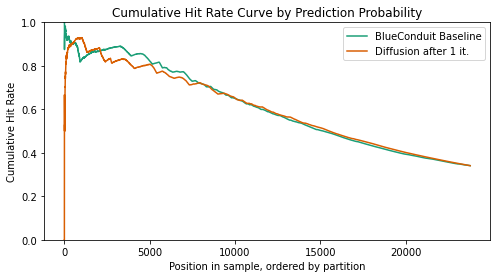

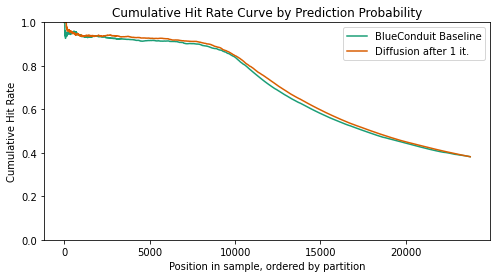

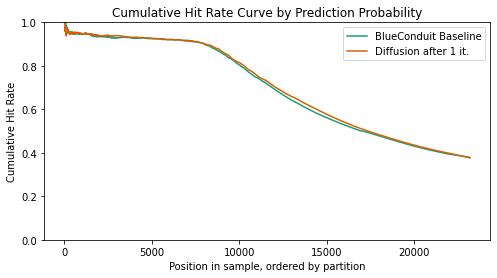

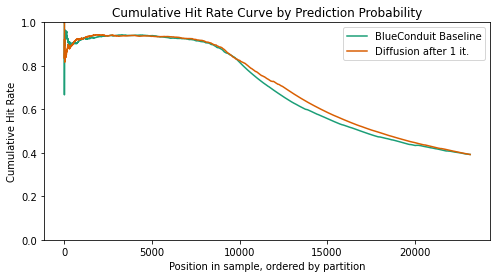

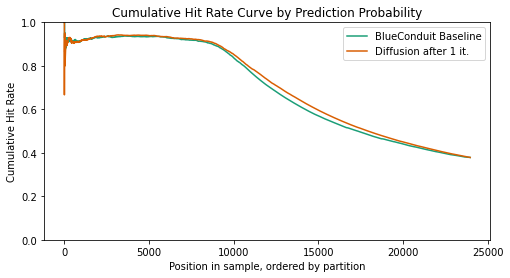

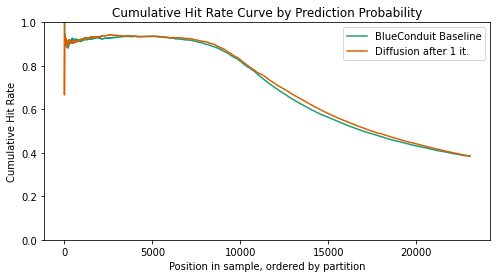

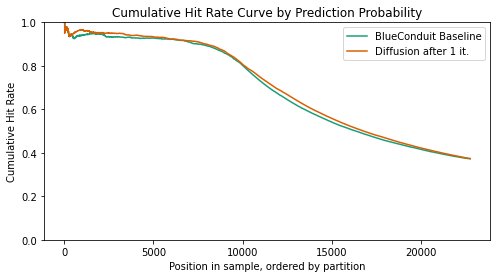

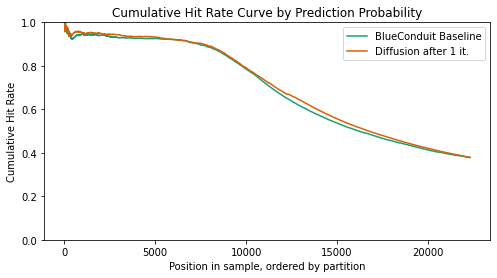

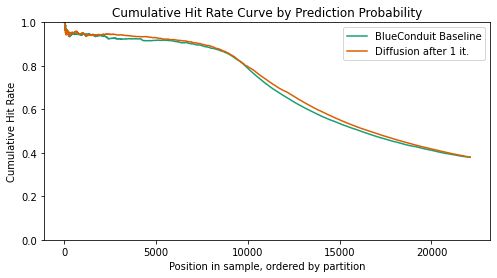

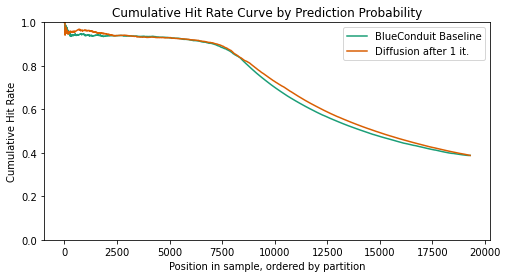

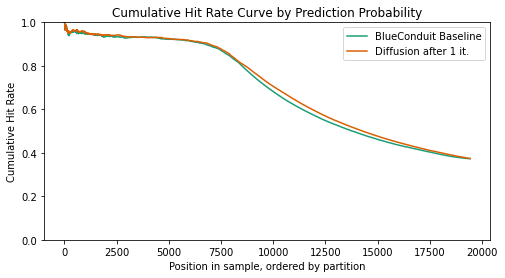

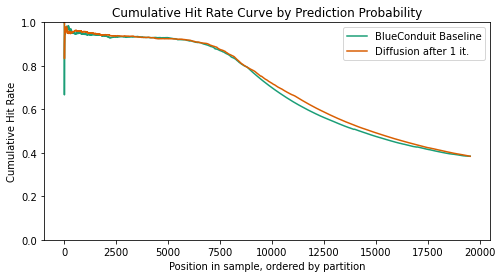

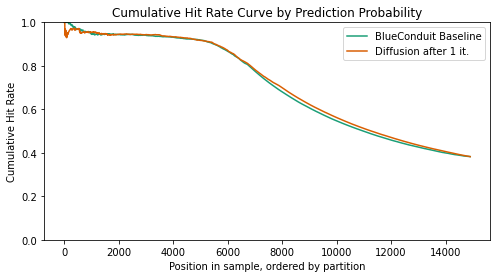

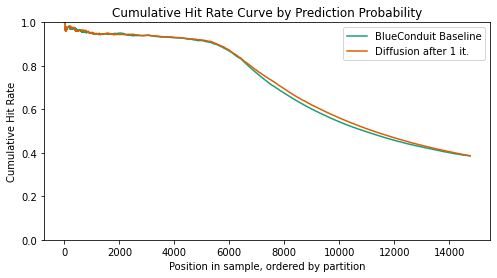

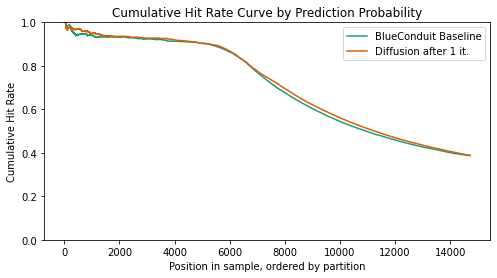

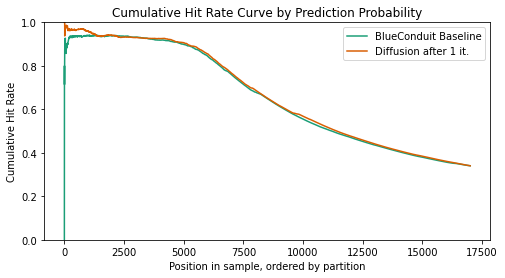

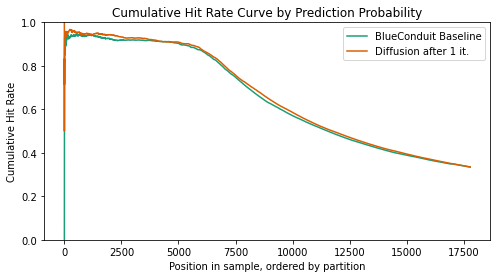

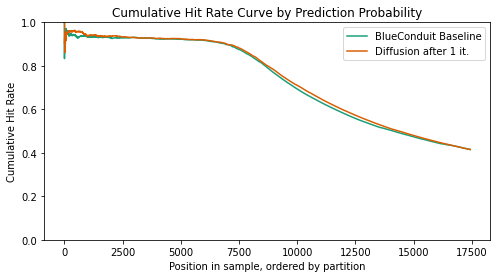

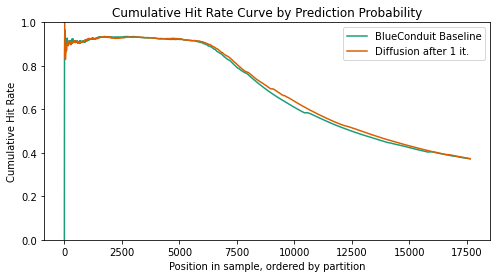

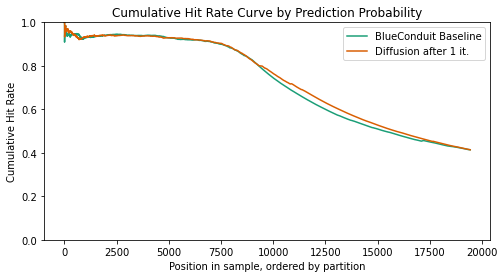

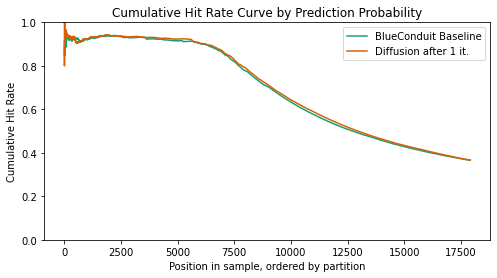

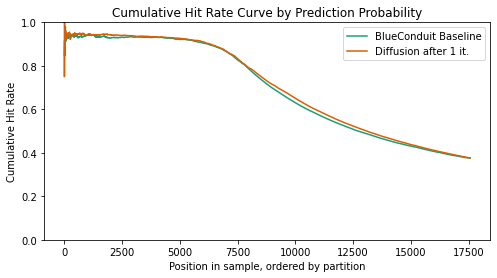

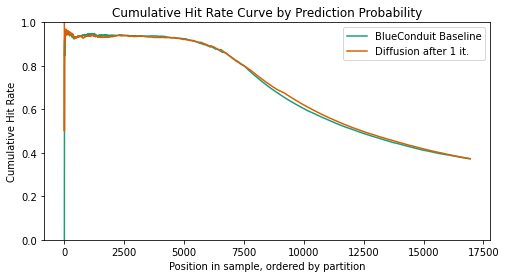

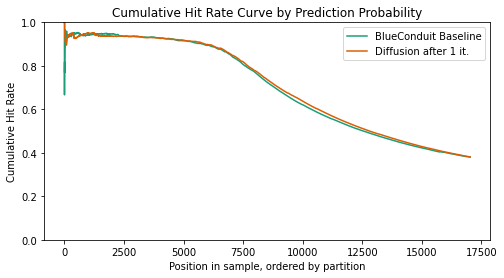

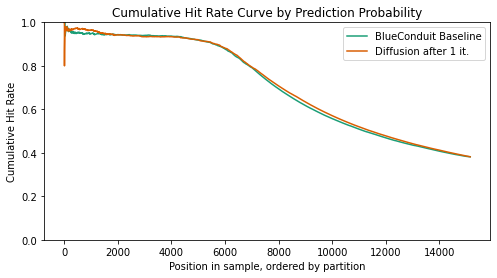

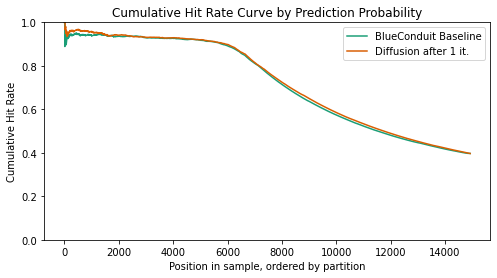

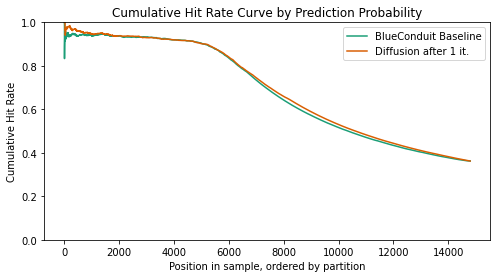

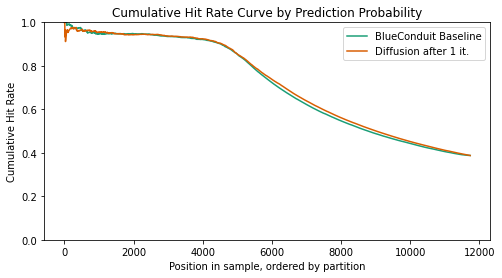

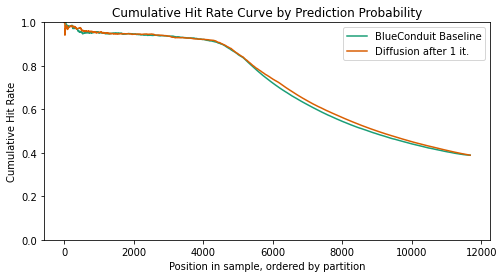

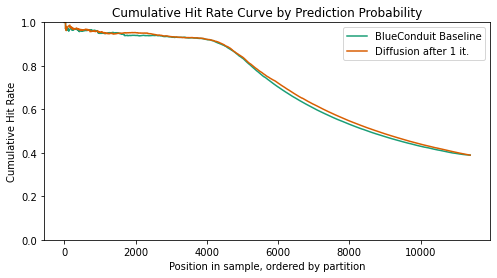

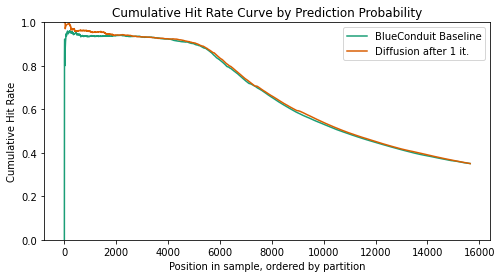

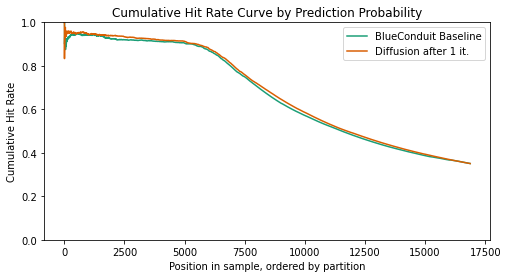

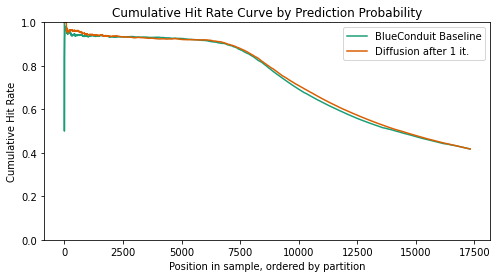

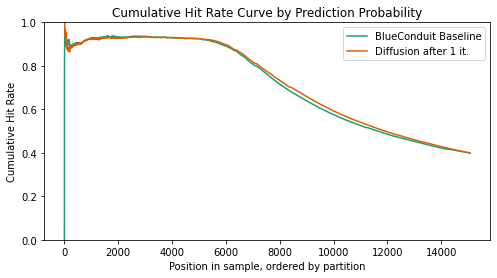

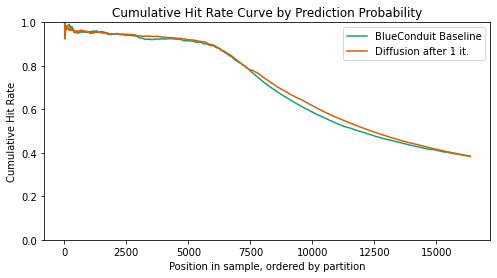

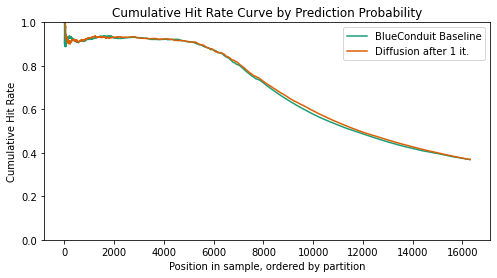

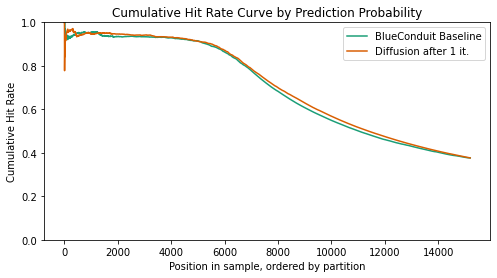

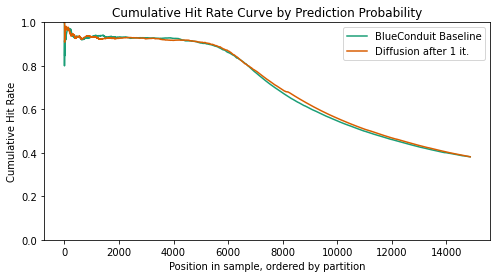

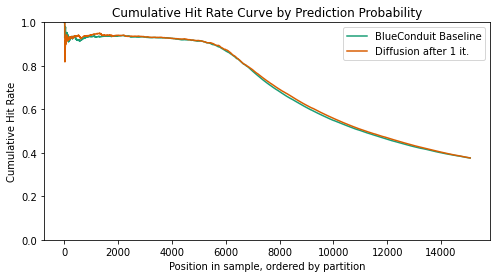

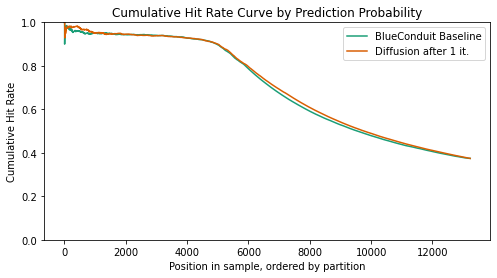

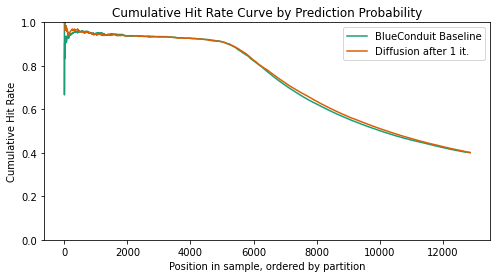

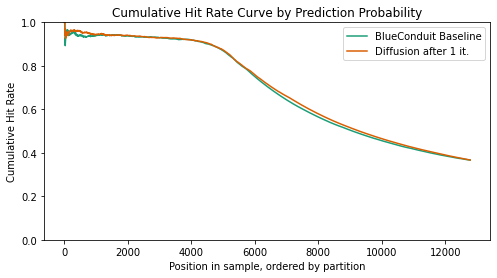

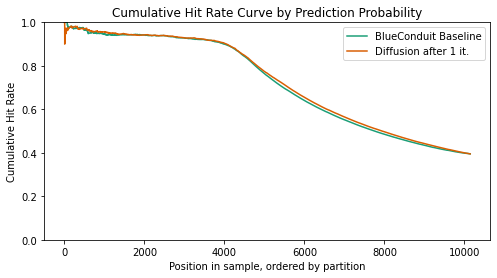

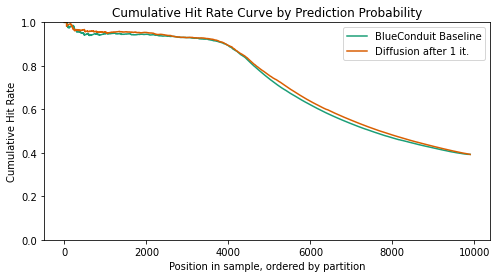

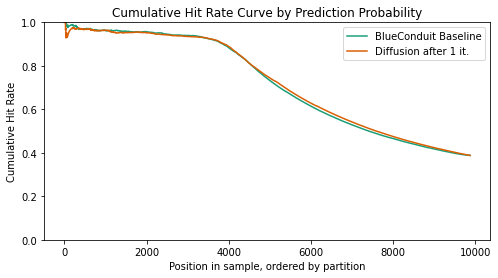

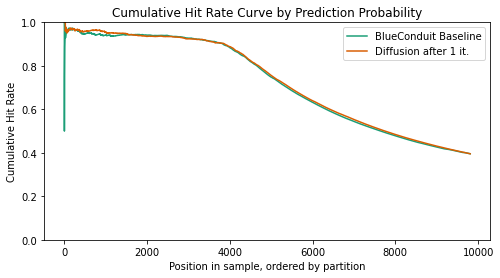

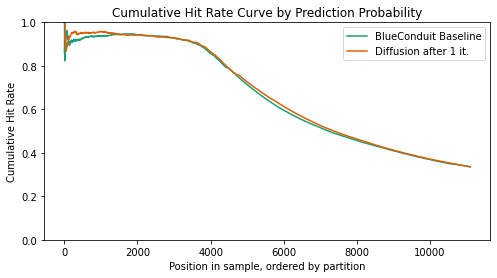

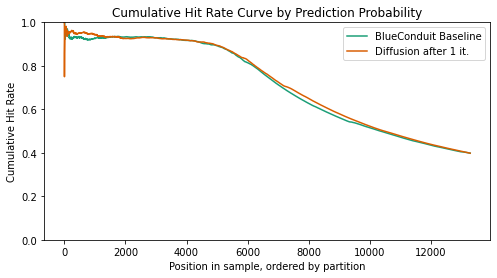

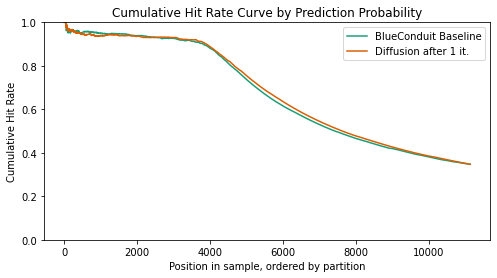

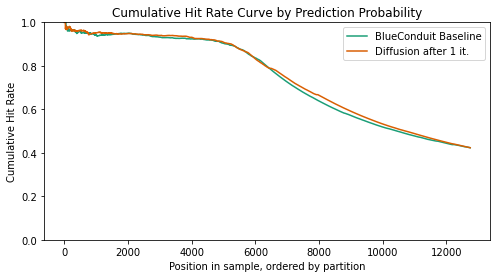

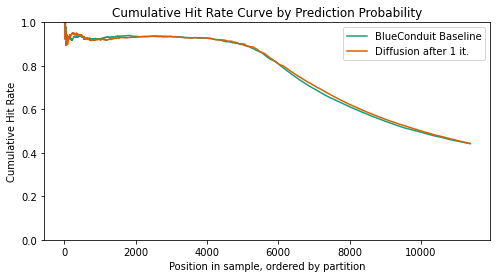

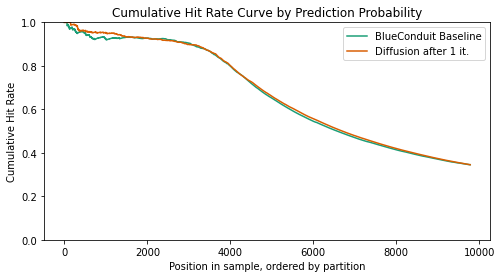

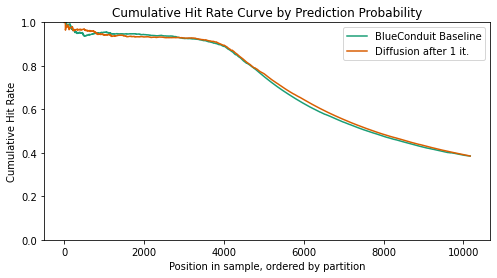

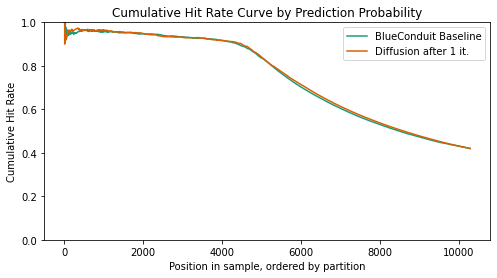

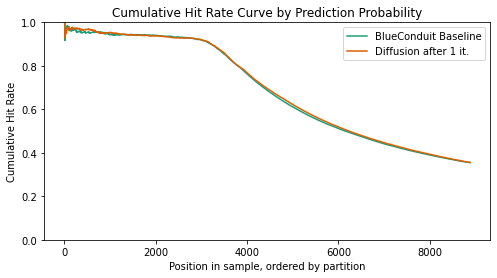

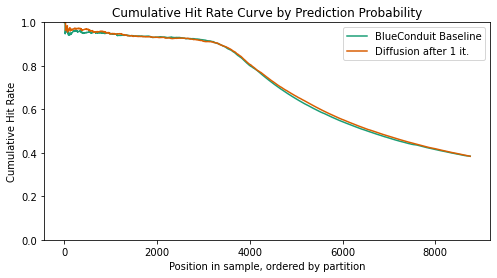

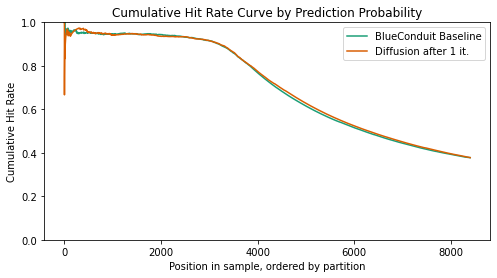

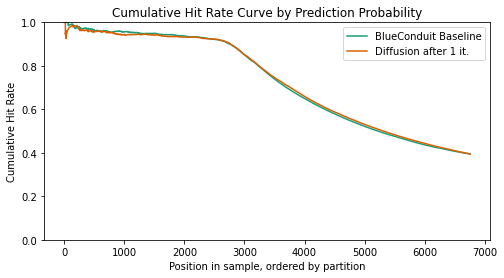

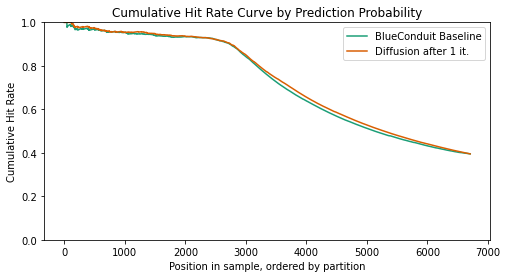

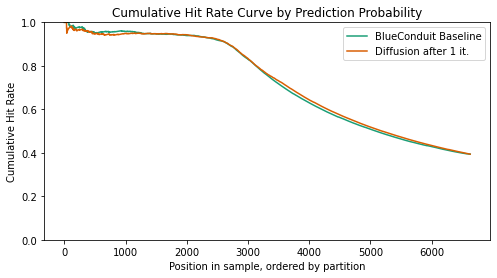

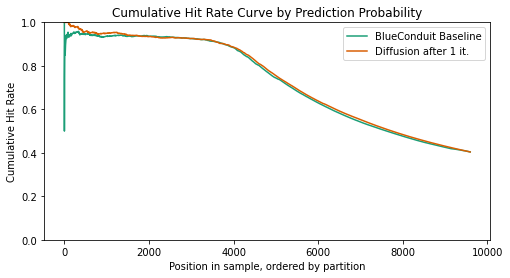

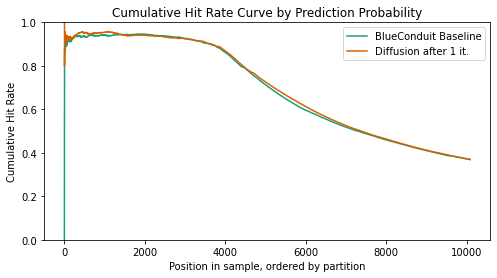

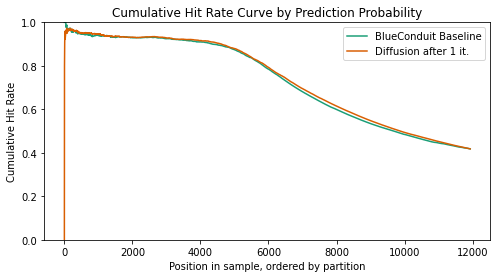

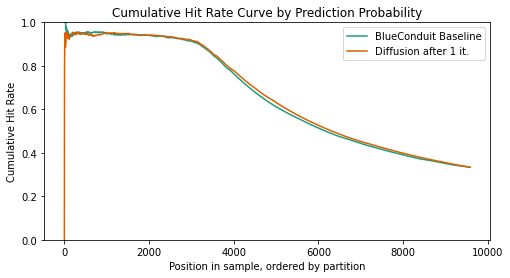

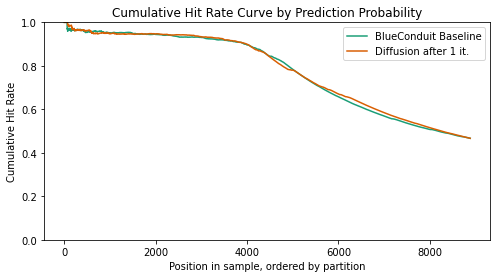

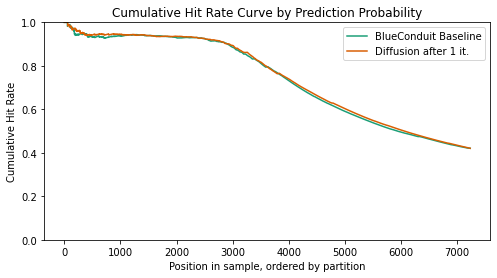

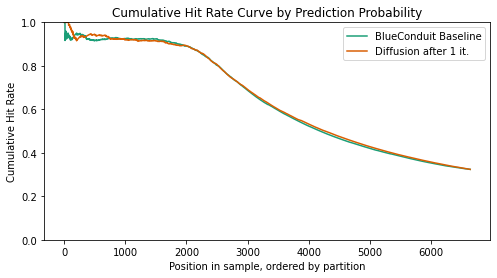

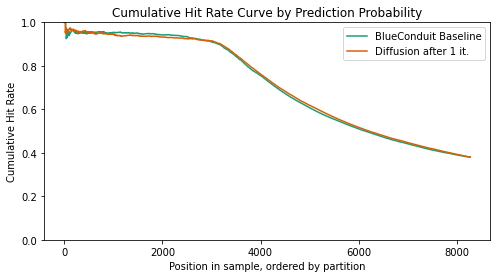

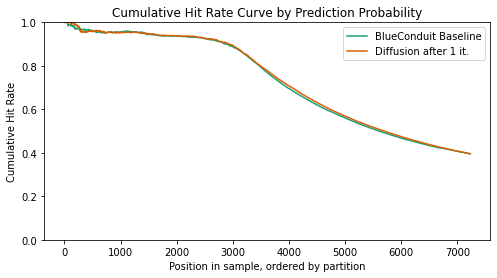

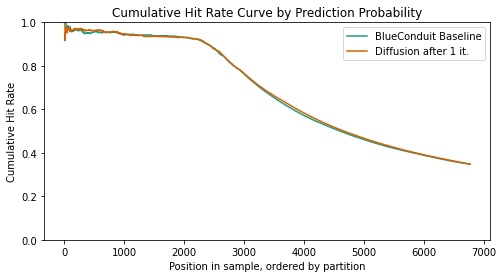

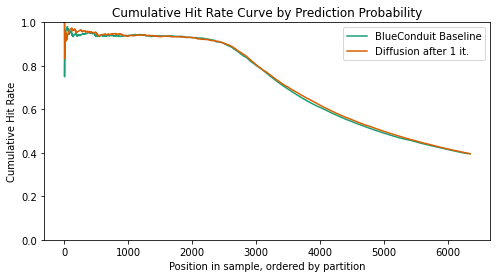

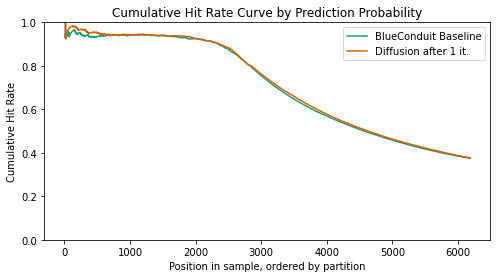

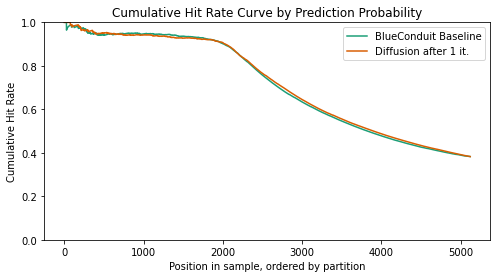

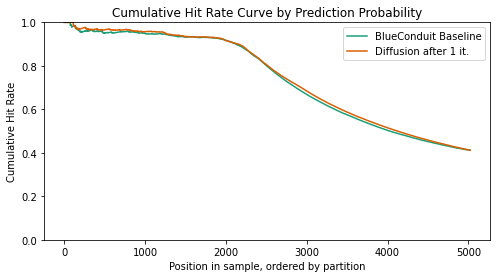

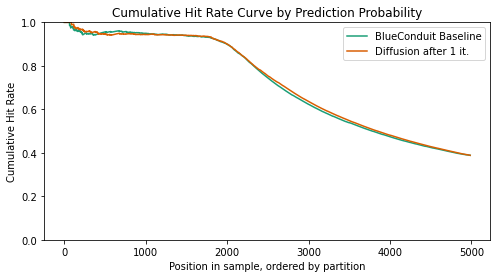

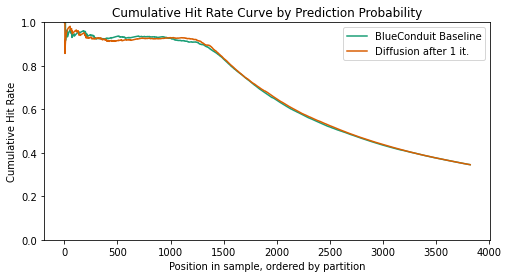

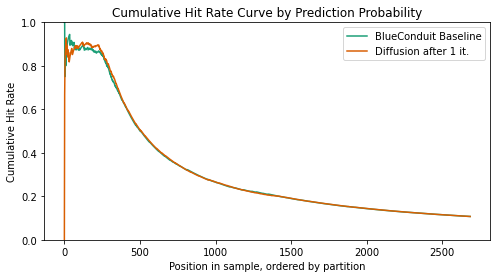

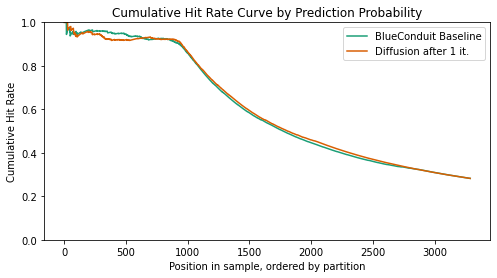

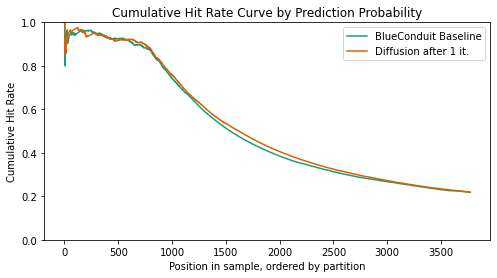

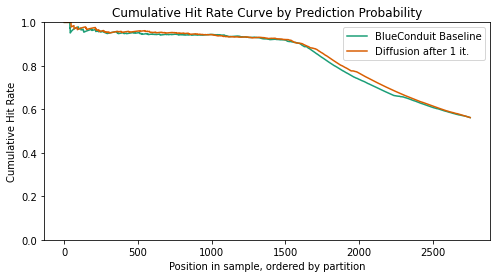

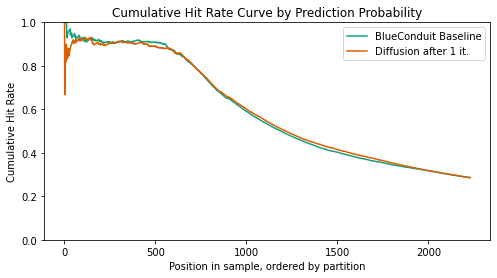

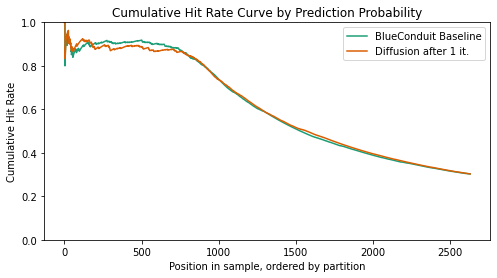

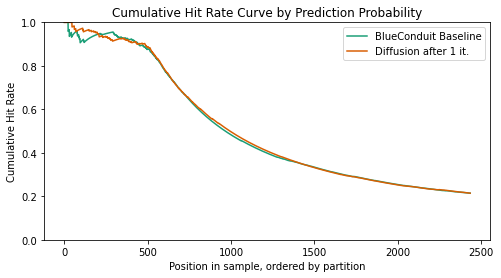

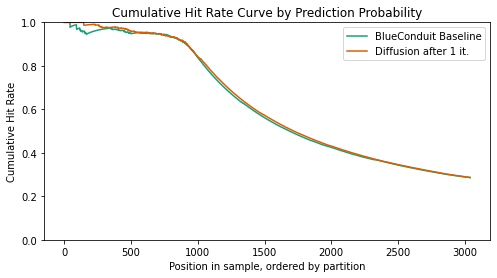

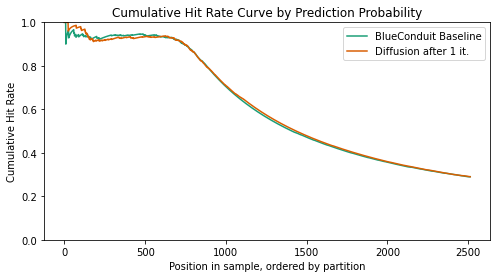

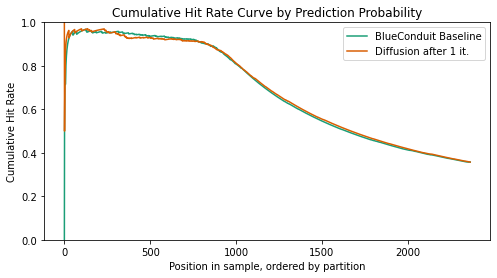

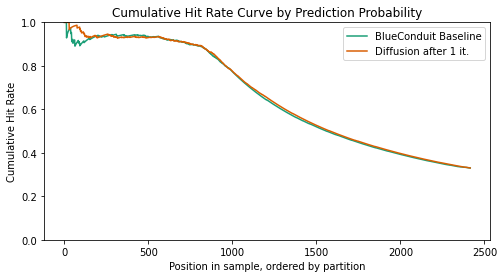

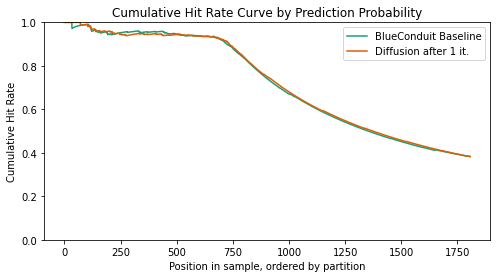

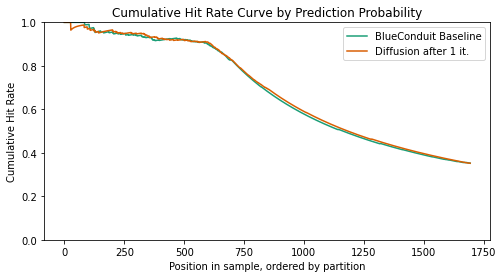

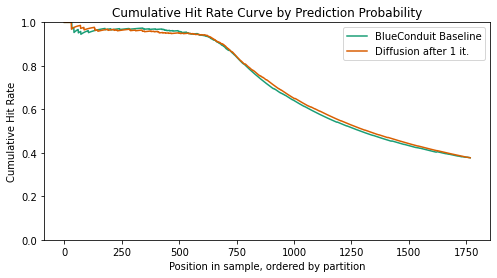

In [ ]:
pred_probs_train_dict = {}
pred_probs_test_dict = {}

for i, train_size in enumerate(train_sizes):
  train_probs_pct = {}
  test_probs_pct = {}
  for j, hex_size in enumerate(resolutions):
    train_probs_res = []
    test_probs_res = []
    hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=hex_size)
    for split in range(3):
      print(f"Working on split {split}...")
      result_dict  = select_data(Xdata, 
                                  Ydata, 
                                  location, 
                                  train_pid_all, 
                                  test_pid_all, 
                                  train_pred_all, 
                                  test_pred_all,
                                  partitions_builder, 
                                  train_size=train_size,
                                  n_hexagons=hex_size,
                                  split=split, 
                                  generate_hexagons=False)
      
      slg = ServiceLineDiffusion(graph, result_dict['train_graph_index'], result_dict['test_graph_index'], 
                                 result_dict['Ytrain'], result_dict['Ytest'], result_dict['train_pred'], result_dict['test_pred'], 
                                 lam=round(0.6, 2))
      out = slg.fit(n_iter=n_iter, verbose=False, neighbor_fn=ServiceLineDiffusion.graph_Kneighbors, neighbor_params={'graph':graph, 'K': 50})

      
      plot_hit_rate_curve(result_dict['Ytest'], [result_dict['test_pred'], slg.curr_test_pred], #, np.random.beta(0.5, 0.5, size=len(result_dict['test_pred']))], 
                          plot_probs=False, labels=['BlueConduit Baseline', f'Diffusion after {1} it.'], #, 'Random Beta(0.5,0.5)'], 
                          mode='partition', parcel_df=hexagons.parcel_gdf, pid_list=result_dict['test_pid'], threshold_init=0.9, min_digs=1, threshold_increment=0.1, 
                          figsize=(8,4), savefig=True, figname=f'{n_iter}iter_{train_size}_{hex_size}_{split}.png', figdir=f'{plot_dir}/diffusion/')
      
      
      
      train_preds = slg.curr_train_pred
      train_probs_res.append(train_preds)
                
      test_preds = slg.curr_test_pred
      test_probs_res.append(test_preds)
    train_probs_pct[f'res_{hex_size}'] = np.array(train_probs_res, dtype='object')
    test_probs_pct[f'res_{hex_size}'] = np.array(test_probs_res, dtype='object')

  pred_probs_train_dict[f'ts_{train_size}'] = train_probs_pct
  pred_probs_test_dict[f'ts_{train_size}'] = test_probs_pct

In [ ]:
np.savez(f'{pred_dir}/diffusion_pred_probs_train.npz', **pred_probs_train_dict)
np.savez(f'{pred_dir}/diffusion_pred_probs_test.npz', **pred_probs_test_dict)

# UPDATED ^

### Hyperparameter Tuning

In [ ]:
pred_probs_train_dict = {}
pred_probs_test_dict = {}
grid_results_logloss = {}
for i, train_size in enumerate(train_sizes):
  train_probs_pct = {}
  test_probs_pct = {}
  for j, hex_size in enumerate(resolutions):
    train_probs_res = []
    test_probs_res = []
    hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=hex_size)
    for split in range(3):
      if split > 0:
        break
      print(f"Working on split {split}...")
      (train_index, test_index, 
      Xtrain, Xtest, Ytrain, Ytest, 
      train_pred, test_pred) = select_data(Xdata, 
                                            Ydata, 
                                            pid, 
                                            train_idx, 
                                            test_idx, 
                                            train_pred_all, 
                                            test_pred_all,
                                            partitions_builder, 
                                            train_size=train_size,
                                            n_hexagons=hex_size,
                                            split=split, 
                                            generate_hexagons=False)
      print(f'Initial logloss: {log_loss(Ytest, test_pred)}')
      for k in k_list:
        grid_results_logloss[k] = {}
        for lam in lam_list:
          print(f"weight on self = {round(lam, 2)}, k={k}")
          slg = ServiceLineDiffusion(graph, train_index, test_index, Ytrain, Ytest, train_pred, test_pred, lam=round(lam, 2))
          out = slg.fit(n_iter=n_iter, verbose=False, neighbor_params={'graph':graph, 'K': k})
          grid_results_logloss[k][lam] = log_loss(Ytest, out[test_index])
          print(log_loss(Ytest, out[test_index]))
          #plot_hit_rate_curve(Ytest, [test_pred, slg.curr_test_pred, np.random.beta(0.5, 0.5, size=len(test_pred))], 
          #                    plot_probs=False, labels=['BlueConduit Baseline', f'Diffusion after {1} it.', 'Random Beta(0.5,0.5)'], 
          #                    mode='partition', parcel_df=hexagons.parcel_gdf, index_list=test_index, threshold_init=0.9, min_digs=1, threshold_increment=0.1, 
          #                    figsize=(8,4), savefig=False, figname=f'{n_iter}iter_{train_size}_{hex_size}_{split}.png', figdir=f'{plot_dir}/diffusion/')
      
      
      
      train_preds = slg.curr_train_pred
      train_probs_res.append(train_preds)
                
      test_preds = slg.curr_test_pred
      test_probs_res.append(test_preds)
    train_probs_pct[f'res_{hex_size}'] = np.array(train_probs_res, dtype='object')
    test_probs_pct[f'res_{hex_size}'] = np.array(test_probs_res, dtype='object')

  pred_probs_train_dict[f'ts_{train_size}'] = train_probs_pct
  pred_probs_test_dict[f'ts_{train_size}'] = test_probs_pct

In [ ]:
# Load predictions
train_pred_diffusion, test_pred_diffusion = load_predictions(pred_dir, 'diffusion')

diff_pred_47_train = train_pred_diffusion['ts_0.1']['res_47']
diff_pred_47_test = test_pred_diffusion['ts_0.1']['res_47']



In [ ]:
train_size = 0.1
hex_size = 22
split = 0

hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=hex_size)

2021-11-18 01:27.53 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 16754.59it/s]

2021-11-18 01:27.56 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 01:27.56 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 01:27.59 [debug    ] Total parcels after join: 26857
2021-11-18 01:27.59 [info     ] Building the connected graph on the partitions.
2021-11-18 01:27.59 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory


In [ ]:
baseline_test_pred = test_pred_all[f"ts_{train_size}"][f"res_{hex_size}"][split]

result_dict  = select_data(Xdata, 
                                  Ydata, 
                                  location, 
                                  train_pid_all, 
                                  test_pid_all, 
                                  train_pred_diffusion, 
                                  test_pred_diffusion,
                                  partitions_builder, 
                                  train_size=train_size,
                                  n_hexagons=hex_size,
                                  split=0, 
                                  generate_hexagons=False)
      

dig_stats_df = dig_stats(hexagons.parcel_gdf, result_dict['test_pid'], result_dict['Ytest'], [baseline_test_pred, result_dict['test_pred']], 
                         strat_names=['Baseline', 'Diffusion'], bins=50, mode='digs_lead_number')

TypeError: ignored

In [ ]:
dig_savings_df = dig_savings(dig_stats_df, 'Baseline', 'Diffusion')
dig_savings_df.tail(50)

Model           Baseline            ...    Diffusion Savings Diffusion over Baseline
Statistics    prob_thres  hit_rate  ...     cost_cum                                
digs_lead_cum                       ...                                             
183                  0.9  0.953125  ...     $987,000                        $-45,000
366                  0.9  0.938462  ...   $1,935,000                        $-42,000
549                  0.9  0.897059  ...   $2,877,000                         $-6,000
732                  0.9  0.910448  ...   $3,813,000                         $27,000
915                  0.9  0.910448  ...   $4,767,000                         $42,000
1098                 0.9  0.953125  ...   $5,694,000                         $57,000
1281                 0.9  0.915000  ...   $6,645,000                         $72,000
1464                 0.9  0.953125  ...   $7,587,000                         $72,000
1647                 0.9  0.933673  ...   $8,544,000                         $69,000
1830                 0.9  0.943299  ...   $9,504,000                         $57,000
2013                 0.9  0.958115  ...  $10,452,000                         $48,000
2196                 0.9  0.875598  ...  $11,406,000                         $87,000
2379                 0.9  0.910448  ...  $12,339,000                        $123,000
2562                 0.9  0.888350  ...  $13,311,000                        $135,000
2745                 0.9  0.948187  ...  $14,274,000                        $117,000
2928                 0.9  0.901478  ...  $15,216,000                        $150,000
3111                 0.9  0.933673  ...  $16,173,000                        $147,000
3294                 0.9  0.871429  ...  $17,142,000                        $174,000
3477                 0.9  0.928934  ...  $18,099,000                        $174,000
3660                 0.9  0.928934  ...  $19,074,000                        $156,000
3843                 0.9  0.892683  ...  $20,037,000                        $174,000
4026                 0.9  0.933673  ...  $20,997,000                        $168,000
4209                 0.9  0.910448  ...  $21,960,000                        $174,000
4392                 0.9  0.897059  ...  $22,929,000                        $183,000
4575                 0.9  0.910448  ...  $23,910,000                        $171,000
4757                 0.9  0.943005  ...  $24,871,000                        $153,000
4940                 0.9  0.901478  ...  $25,822,000                        $177,000
5123                 0.9  0.958115  ...  $26,788,000                        $150,000
5306                 0.9  0.938462  ...  $27,775,000                        $114,000
5489                 0.9  0.938462  ...  $28,783,000                         $57,000
5672                 0.9  0.901478  ...  $29,785,000                         $30,000
5855                 0.9  0.901478  ...  $30,763,000                         $27,000
6038                 0.9  0.875598  ...  $31,732,000                         $51,000
6221                 0.9  0.888350  ...  $32,728,000                         $39,000
6404                 0.9  0.839450  ...  $33,718,000                         $69,000
6587                 0.8  0.843318  ...  $34,687,000                        $117,000
6770                 0.8  0.905941  ...  $35,773,000                          $3,000
6953                 0.8  0.816964  ...  $36,790,000                         $24,000
7136                 0.8  0.775424  ...  $37,777,000                        $111,000
7319                 0.7  0.788793  ...  $38,848,000                        $102,000
7502                 0.7  0.743902  ...  $39,916,000                        $138,000
7685                 0.6  0.743902  ...  $41,041,000                        $117,000
7868                 0.5  0.685393  ...  $42,211,000                        $114,000
8051                 0.4  0.539823  ...  $43,435,000                        $273,000
8234 

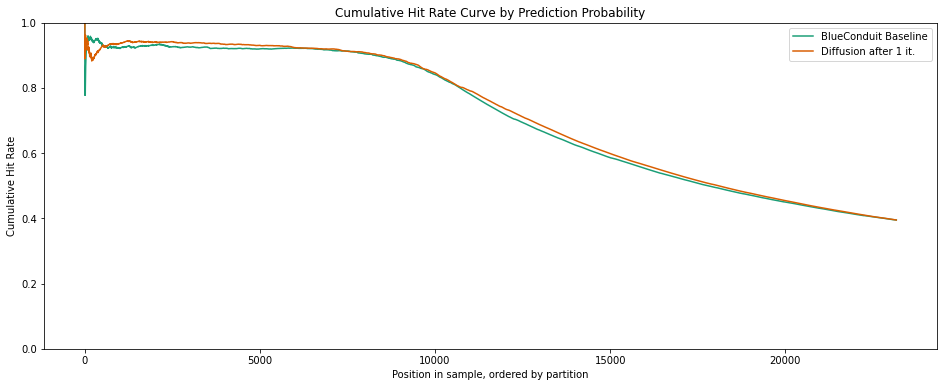

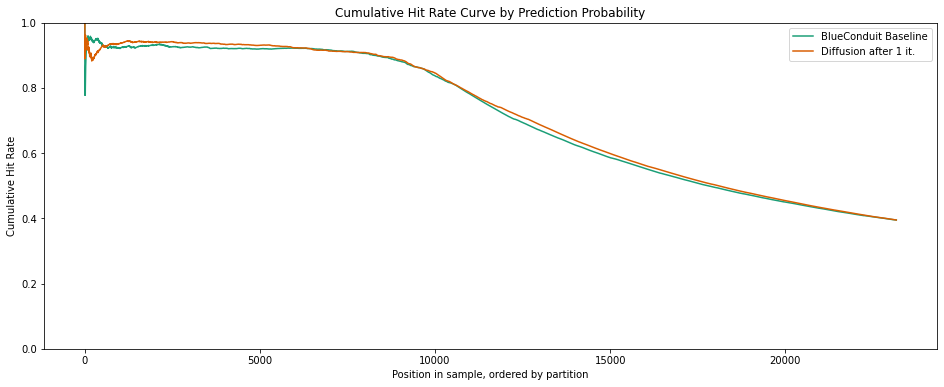

In [ ]:
plot_hit_rate_curve(Ytest, [baseline_test_pred, test_pred], 
                              plot_probs=False, labels=['BlueConduit Baseline', f'Diffusion after {1} it.'], 
                              mode='partition', parcel_df=hexagons.parcel_gdf, index_list=test_index, threshold_init=0.9, 
                    min_digs=1, threshold_increment=0.1, 
                              figsize=(16,6))
plot_hit_rate_curve(Ytest, [baseline_test_pred, test_pred], 
                              plot_probs=False, labels=['BlueConduit Baseline', f'Diffusion after {1} it.'], 
                              mode='partition', parcel_df=hexagons.parcel_gdf, index_list=test_index, threshold_init=0.9, 
                    min_digs=1, threshold_increment=0.2, 
                              figsize=(16,6))
      

## Milestone 2: Figures

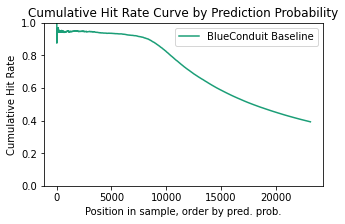

In [ ]:
result_dict  = select_data(Xdata, 
                                  Ydata, 
                                  location, 
                                  train_pid_all, 
                                  test_pid_all, 
                                  train_pred_all, 
                                  test_pred_all,
                                  partitions_builder, 
                                  train_size=train_size,
                                  n_hexagons=hex_size,
                                  split=split, 
                                  generate_hexagons=False)
plot_hit_rate_curve(result_dict['Ytest'], result_dict['test_pred'], plot_probs=False, labels=['BlueConduit Baseline'], mode='all', figsize=(5, 3))

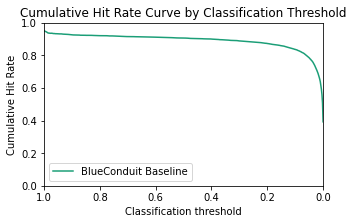

In [ ]:
plot_hit_rate_curve(result_dict['Ytest'], result_dict['test_pred'], plot_probs=False, labels=['BlueConduit Baseline'], mode='all', order_by_prob=True, figsize=(5, 3))

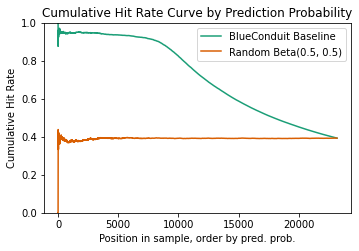

In [ ]:
plot_hit_rate_curve(result_dict['Ytest'], [result_dict['test_pred'], np.random.beta(0.5, 0.5, size=len(result_dict['test_pred']))], plot_probs=False, 
                    labels=['BlueConduit Baseline', 'Random Beta(0.5, 0.5)'], mode='all', figsize=(5.5,3.5))

## Plotting

In [ ]:
hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=22)

2021-11-15 00:45.32 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 15903.15it/s]

2021-11-15 00:45.35 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-15 00:45.35 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-15 00:45.38 [debug    ] Total parcels after join: 26857
2021-11-15 00:45.38 [info     ] Building the connected graph on the partitions.
2021-11-15 00:45.39 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory


In [ ]:
def plot_avg_prediction(hexagons, pid, slg, figsize=(16,6), col='output_pred'):
  part_gdf = hexagons.partition_gdf.copy()
  train_df_w_part_id = pid.iloc[train_index].merge(hexagons.parcel_gdf[['parcel_id', 'partition_ID', 'has_lead']].astype(float), 
                            left_on='pid', right_on='parcel_id', how='left').drop(['Latitude', 'Longitude', 'geometry', 'parcel_id'], 
                                                                                   axis=1)
  train_df_w_part_id['output_pred'] = slg.curr_train_pred

  test_df_w_part_id = pid.iloc[test_index].merge(hexagons.parcel_gdf[['parcel_id', 'partition_ID', 'has_lead']].astype(float), 
                            left_on='pid', right_on='parcel_id', how='left').drop(['Latitude', 'Longitude', 'geometry', 'parcel_id'], 
                                                                                   axis=1)
                            
  test_df_w_part_id['output_pred'] = slg.curr_test_pred
  df_w_part_id = train_df_w_part_id.append(test_df_w_part_id)
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  part_gdf.merge(right=df_w_part_id.groupby('partition_ID').mean()[col], on='partition_ID').plot(column=col, figsize=(16,6), legend=True, ax=ax)
  ax.set_axis_off()
  plt.show()





/usr/local/lib/python3.7/dist-packages/blue_conduit_spatial/modeling/diffusion.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lead_vals = np.array([self._get_lead_value(idx) for idx in range(self.graph.shape[0])]).flatten().astype(float)


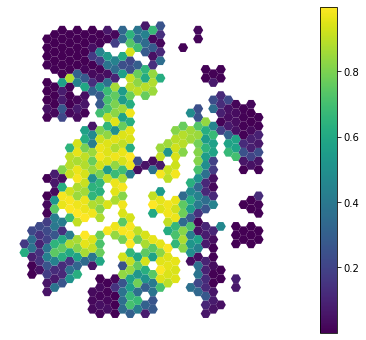

/usr/local/lib/python3.7/dist-packages/blue_conduit_spatial/modeling/diffusion.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lead_vals = np.array([self._get_lead_value(idx) for idx in range(self.graph.shape[0])]).flatten().astype(float)


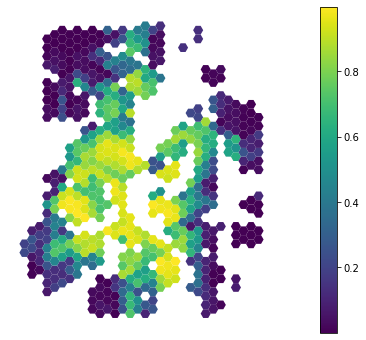

In [ ]:
slg = ServiceLineDiffusion(graph, train_index, test_index, Ytrain, Ytest, train_pred, test_pred)
out = slg.fit(n_iter=0, verbose=False)
plot_avg_prediction(hexagons, pid, slg)
out = slg.fit(n_iter=100, verbose=False)
plot_avg_prediction(hexagons, pid, slg)


In [ ]:
def plot_varof_prediction(hexagons, pid, slg, figsize=(16,6), col='output_pred'):
  part_gdf = hexagons.partition_gdf.copy()
  train_df_w_part_id = pid.iloc[train_index].merge(hexagons.parcel_gdf[['parcel_id', 'partition_ID', 'has_lead']].astype(float), 
                            left_on='pid', right_on='parcel_id', how='left').drop(['Latitude', 'Longitude', 'geometry', 'parcel_id'], 
                                                                                   axis=1)
  train_df_w_part_id['output_pred'] = slg.curr_train_pred

  test_df_w_part_id = pid.iloc[test_index].merge(hexagons.parcel_gdf[['parcel_id', 'partition_ID', 'has_lead']].astype(float), 
                            left_on='pid', right_on='parcel_id', how='left').drop(['Latitude', 'Longitude', 'geometry', 'parcel_id'], 
                                                                                   axis=1)
                            
  test_df_w_part_id['output_pred'] = slg.curr_test_pred
  df_w_part_id = train_df_w_part_id.append(test_df_w_part_id)
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  part_gdf.merge(right=df_w_part_id.groupby('partition_ID').std()[col], on='partition_ID').plot(column=col, figsize=(16,6), legend=True, ax=ax)
  ax.set_axis_off()
  plt.show()

/usr/local/lib/python3.7/dist-packages/blue_conduit_spatial/modeling/diffusion.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lead_vals = np.array([self._get_lead_value(idx) for idx in range(self.graph.shape[0])]).flatten().astype(float)


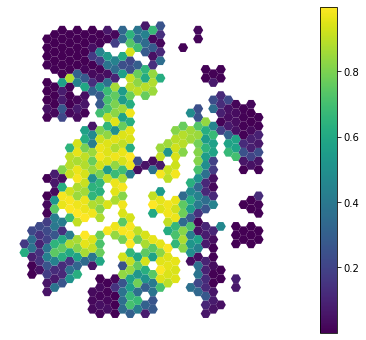

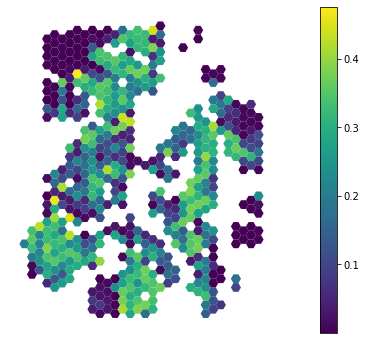

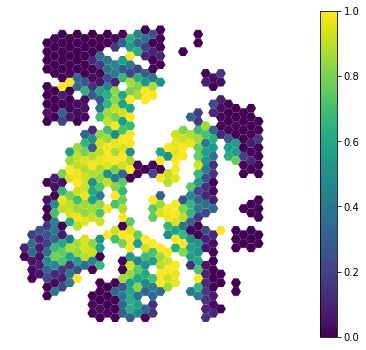

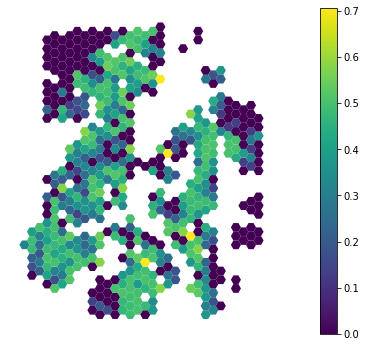

/usr/local/lib/python3.7/dist-packages/blue_conduit_spatial/modeling/diffusion.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lead_vals = np.array([self._get_lead_value(idx) for idx in range(self.graph.shape[0])]).flatten().astype(float)


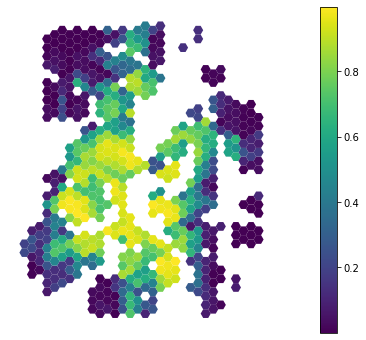

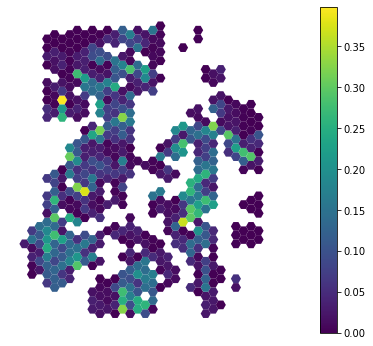

In [ ]:
slg = ServiceLineDiffusion(graph, train_index, test_index, Ytrain, Ytest, train_pred, test_pred)
out = slg.fit(n_iter=0, verbose=False)
plot_avg_prediction(hexagons, pid, slg)
plot_varof_prediction(hexagons, pid, slg)
plot_avg_prediction(hexagons, pid, slg, col='has_lead')
plot_varof_prediction(hexagons, pid, slg, col='has_lead')
out = slg.fit(n_iter=100, verbose=False)
plot_avg_prediction(hexagons, pid, slg)
plot_varof_prediction(hexagons, pid, slg)

In [ ]:
train_idx.keys()

for ts in train_idx.keys():
  print(f"train size: {ts}")
  for res in list(train_idx['ts_0.1'].keys()):
    print(res)
    for i in range(3):
      tr_size = train_idx[ts][res][i].shape[0]
      te_size = test_idx[ts][res][i].shape[0]
      print(tr_size + te_size)

train size: ts_0.1
res_5
26161
26161
26161
res_10
25585
25585
25585
res_22
24332
24332
24332
res_47
21647
21647
21647
res_99
16490
16490
16490
train size: ts_0.3
res_5
26161
26161
26161
res_10
25585
25585
25585
res_22
24332
24332
24332
res_47
21647
21647
21647
res_99
16490
16490
16490
train size: ts_0.4
res_5
26161
26161
26161
res_10
25585
25585
25585
res_22
24332
24332
24332
res_47
21647
21647
21647
res_99
16490
16490
16490
train size: ts_0.6
res_5
26161
26161
26161
res_10
25585
25585
25585
res_22
24332
24332
24332
res_47
21647
21647
21647
res_99
16490
16490
16490
train size: ts_0.7
res_5
26161
26161
26161
res_10
25585
25585
25585
res_22
24332
24332
24332
res_47
21647
21647
21647
res_99
16490
16490
16490
train size: ts_0.9
res_5
26161
26161
26161
res_10
25585
25585
25585
res_22
24332
24332
24332
res_47
21647
21647
21647
res_99
16490
16490
16490


## Plot maps in order of digs

In [ ]:
test = hexagons.parcel_gdf.set_index('pid').loc[result_dict['test_pid']]

In [ ]:
test['baseline_pred'] = baseline_test_pred
test['diffusion_pred'] = result_dict['test_pred']

In [ ]:
up_threshold = 0.7
low_threshold = up_threshold - 0.1
test['baseline_dig'] = (test['baseline_pred'].between(low_threshold, up_threshold)).astype(int)
test['diffusion_dig'] = (test['diffusion_pred'].between(low_threshold, up_threshold)).astype(int)
test['dangerous'] = result_dict['Ytest']
part_gdf = hexagons.partition_gdf
outcome_df = part_gdf.merge(right=test.groupby('partition_ID').sum()[['baseline_dig', 'diffusion_dig', 'dangerous']], left_on='partition_ID', right_on='partition_ID')
outcome_df = outcome_df.merge(right=outcome_df.sort_values('baseline_dig', ascending=False).reset_index()['partition_ID'].reset_index().rename({'index': 'baseline_order'}, axis=1), 
                 left_on='partition_ID', right_on='partition_ID')
outcome_df = outcome_df.merge(right=outcome_df.sort_values('diffusion_dig', ascending=False).reset_index()['partition_ID'].reset_index().rename({'index': 'diffusion_order'}, axis=1), 
                 left_on='partition_ID', right_on='partition_ID')
outcome_df['diffusion_n_earlier'] = outcome_df['baseline_order'] - outcome_df['diffusion_order']
outcome_df['baseline_diff'] = outcome_df['dangerous'] - outcome_df['baseline_dig']
outcome_df['diffusion_diff'] = outcome_df['dangerous'] - outcome_df['diffusion_dig']

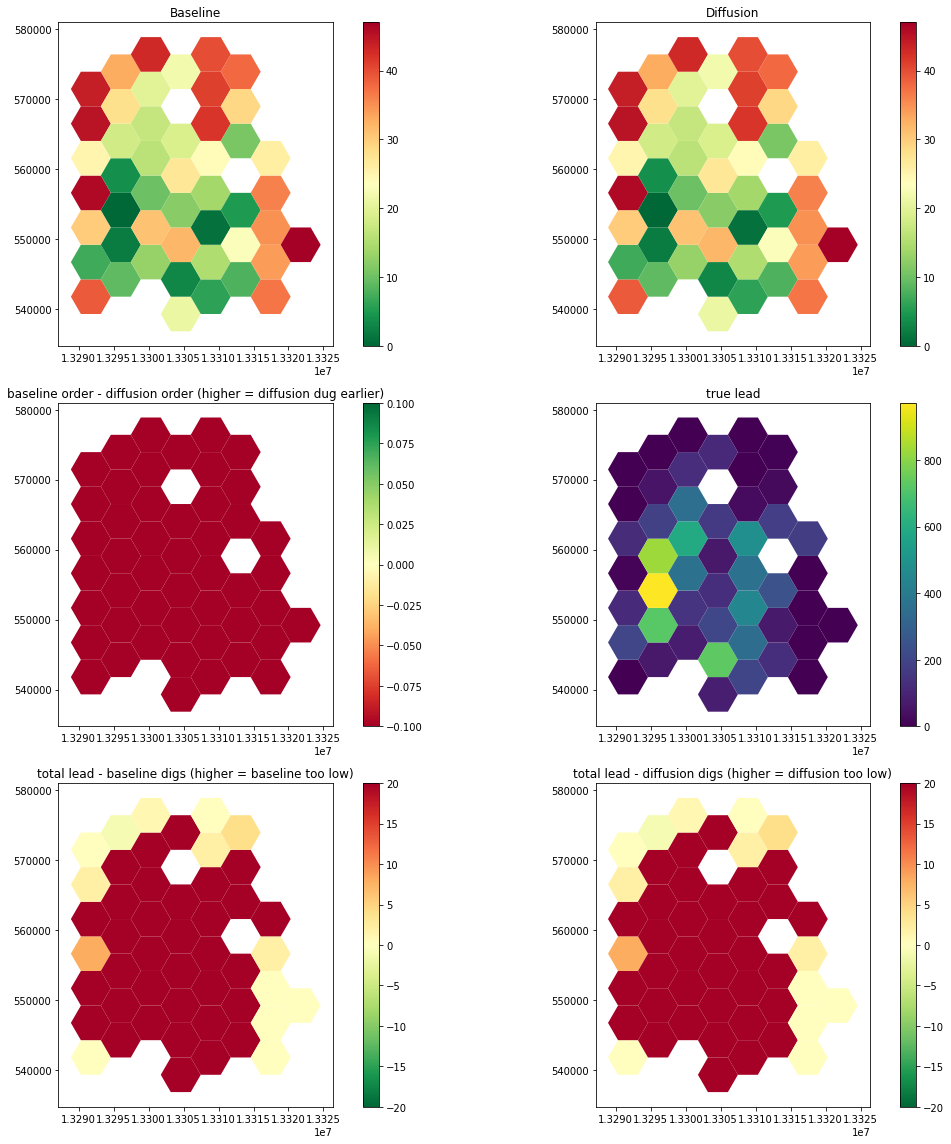

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(16,16))
axs = axs.flatten()
outcome_df.plot(column='baseline_order', legend=True, ax=axs[0], cmap='RdYlGn_r')
axs[0].set_title('Baseline')
outcome_df.plot(column='diffusion_order', legend=True, ax=axs[1], cmap='RdYlGn_r')
axs[1].set_title('Diffusion')
outcome_df.plot(column='diffusion_n_earlier', legend=True, ax=axs[2], cmap='RdYlGn')
axs[2].set_title('baseline order - diffusion order (higher = diffusion dug earlier)')
outcome_df.plot(column='dangerous', legend=True, ax=axs[3], cmap='viridis')
axs[3].set_title('true lead')
outcome_df.plot(column='baseline_diff', legend=True, ax=axs[4],  cmap='RdYlGn_r', vmin=-20, vmax=20)
axs[4].set_title('total lead - baseline digs (higher = baseline too low)')
outcome_df.plot(column='diffusion_diff', legend=True, ax=axs[5], cmap='RdYlGn_r', vmin=-20, vmax=20)
axs[5].set_title('total lead - diffusion digs (higher = diffusion too low)')
plt.tight_layout()
plt.show()

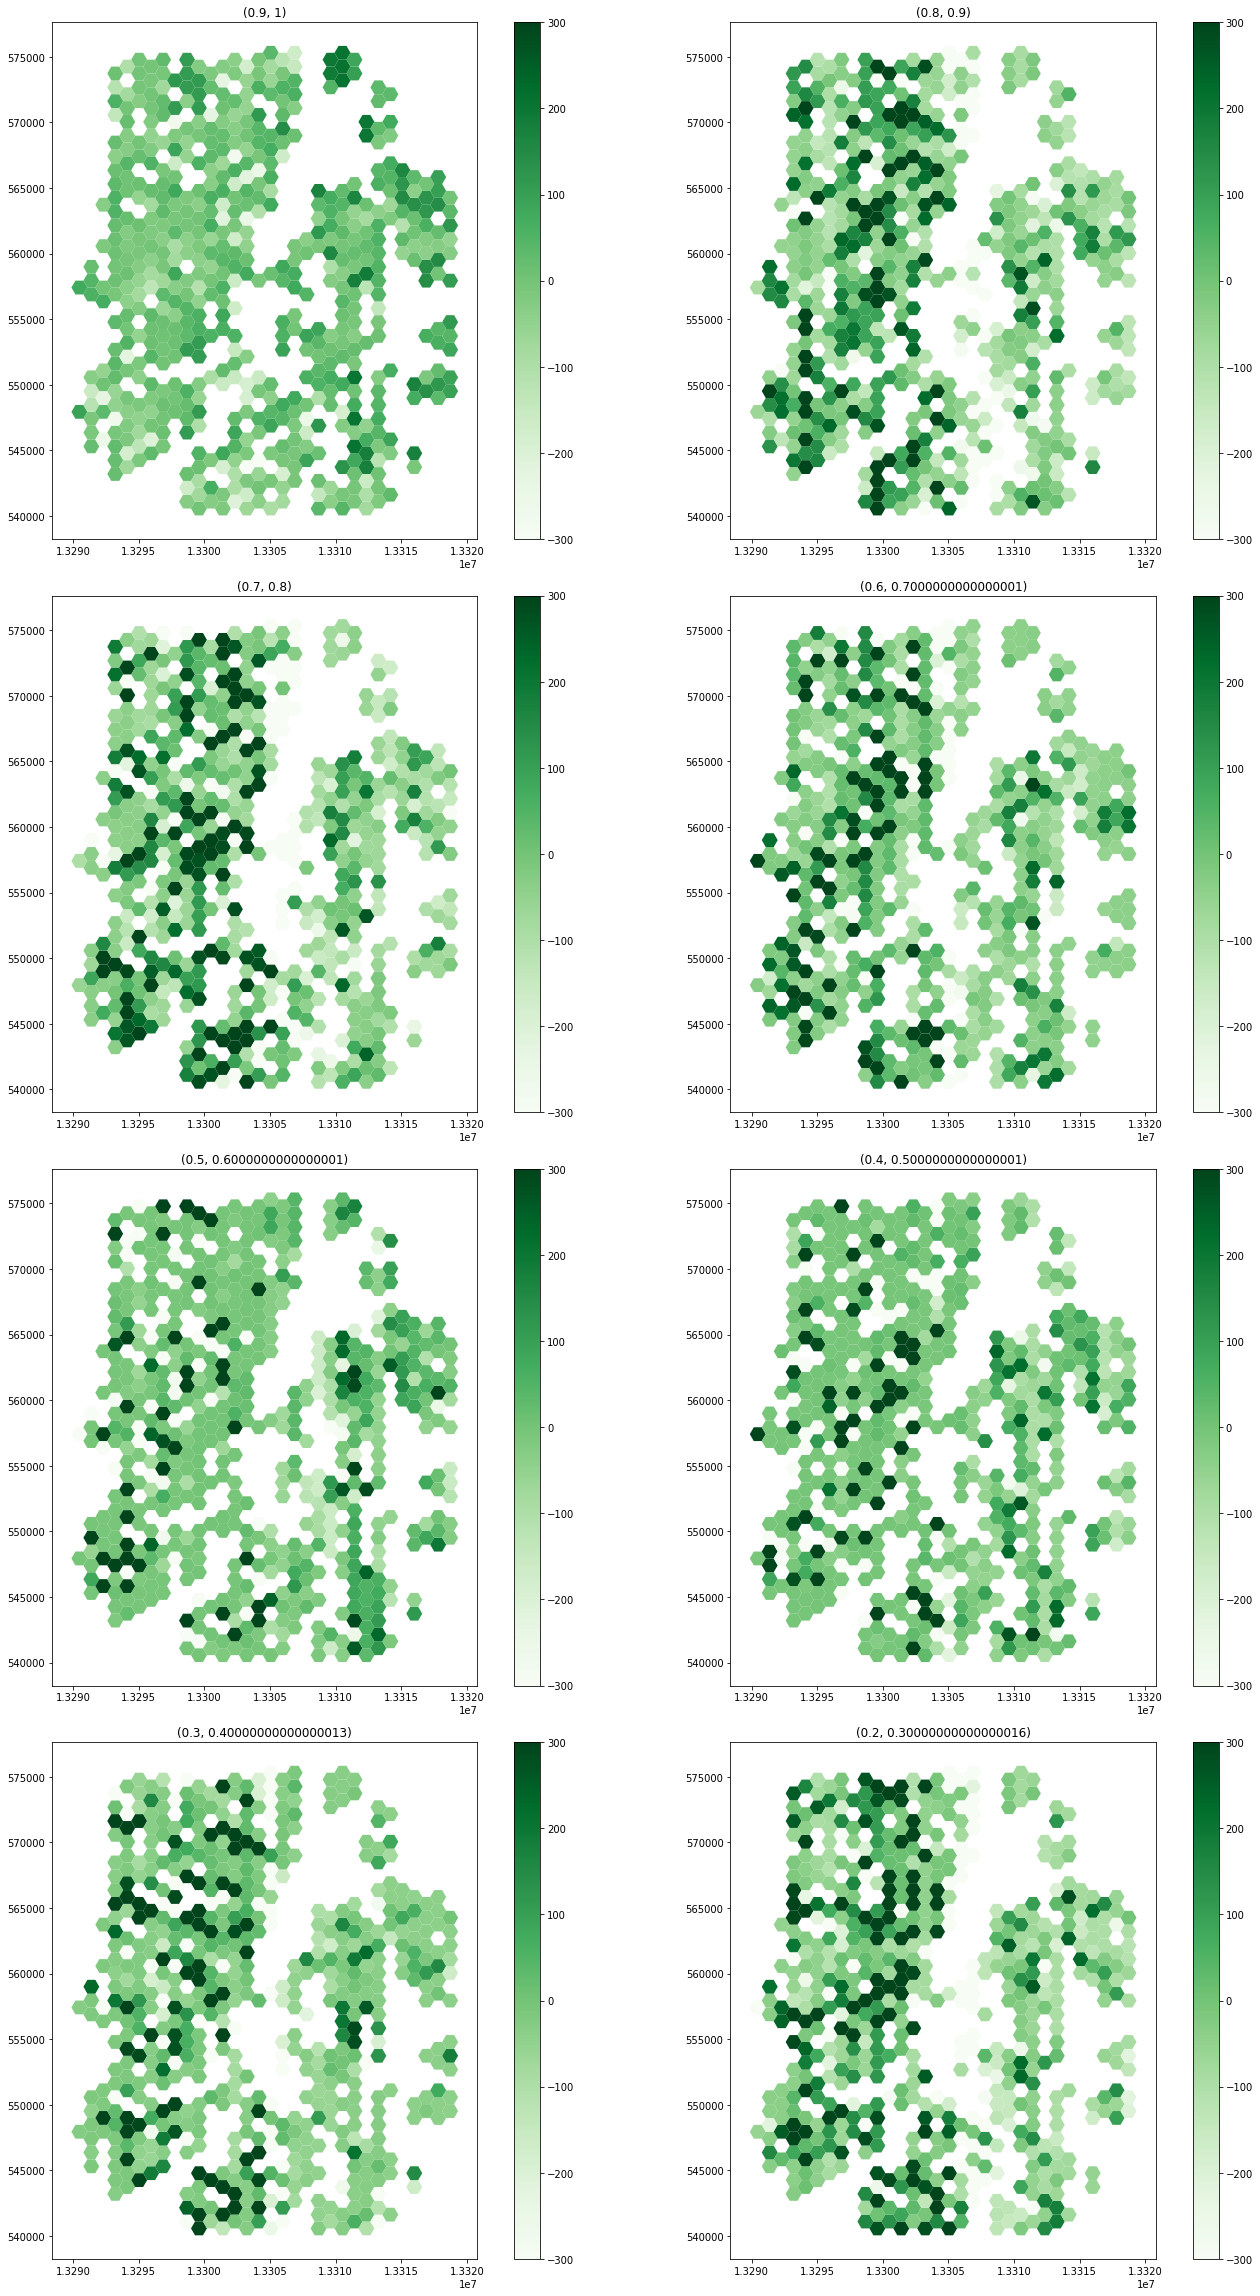

In [ ]:
pd.options.mode.chained_assignment = None
up_threshold = 1
fig, axs = plt.subplots(4, 2, figsize=(20,32))
axs = axs.flatten()
i = 0
while up_threshold > 0.3: 
  low_threshold = round(up_threshold - 0.1, 1)
  test['baseline_dig'] = (test['baseline_pred'].between(low_threshold, up_threshold)).astype(int)
  test['diffusion_dig'] = (test['diffusion_pred'].between(low_threshold, up_threshold)).astype(int)
  test['dangerous'] = Ytest
  part_gdf = hexagons.partition_gdf
  outcome_df = part_gdf.merge(right=test.groupby('partition_ID').sum()[['baseline_dig', 'diffusion_dig', 'dangerous']], left_on='partition_ID', right_on='partition_ID')
  outcome_df = outcome_df.merge(right=outcome_df.sort_values('baseline_dig', ascending=False).reset_index()['partition_ID'].reset_index().rename({'index': 'baseline_order'}, axis=1), 
                  left_on='partition_ID', right_on='partition_ID')
  outcome_df = outcome_df.merge(right=outcome_df.sort_values('diffusion_dig', ascending=False).reset_index()['partition_ID'].reset_index().rename({'index': 'diffusion_order'}, axis=1), 
                  left_on='partition_ID', right_on='partition_ID')
  outcome_df['diffusion_n_earlier'] = outcome_df['baseline_order'] - outcome_df['diffusion_order']
  outcome_df['baseline_diff'] = outcome_df['dangerous'] - outcome_df['baseline_dig']
  outcome_df['diffusion_diff'] = outcome_df['dangerous'] - outcome_df['diffusion_dig']
  outcome_df.plot(column='diffusion_n_earlier', legend=True, cmap='Greens', ax=axs[i], vmin=-300, vmax=300)
  axs[i].set_title(f"({low_threshold}, {up_threshold})")
  up_threshold -= 0.1
  i += 1
plt.tight_layout()
plt.show()
  